In [1]:
from src import SQL_Executor, SQL_Queries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

executor = SQL_Executor()
query = SQL_Queries.Payment()
df = executor.execute_query(query.define_dpd_aggregate())
t_df = executor.execute_query(query.calculate_dpd90_trend())

In [2]:
dpd = df.copy()
scheduled_date = pd.to_datetime(dpd['scheduled_date'])
payment_date = pd.to_datetime(dpd['payment_date'])
today = pd.Timestamp.today()

conditions = [
    payment_date > scheduled_date,
    payment_date.isna(),
    payment_date <= scheduled_date
]

choices = [
    (payment_date - scheduled_date).dt.days,
    np.maximum((today - scheduled_date).dt.days, 0),
    0
]

dpd['dpd'] = np.select(conditions, choices, default=0)
dpd = dpd.drop(columns=['payment_date', 'scheduled_date'])

dpd90 = dpd.copy()
dpd90['dpd90'] = (dpd90['dpd'] >= 90).astype(int)
dpd90 = dpd90.groupby('transaction_id').agg({
    'dpd90': 'max'
})
dpd90 = t_df.merge(dpd90, on='transaction_id', how='left')

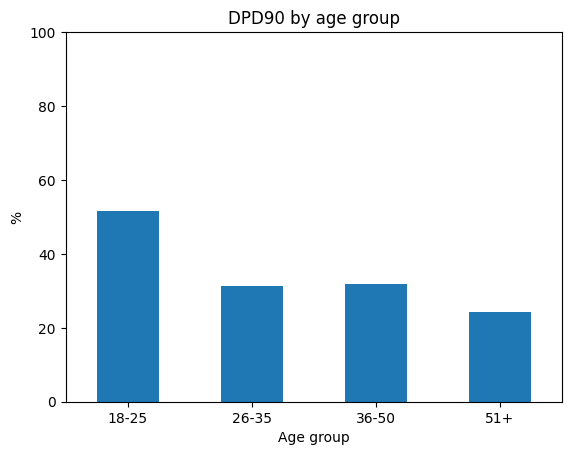

In [3]:
bins = [18, 26, 36, 51, 100]
labels = ['18-25', '26-35', '36-50', '51+']

dpd90_rates_age = dpd90.copy().drop(columns='income')
dpd90_rates_age['group_age'] = pd.cut(dpd90_rates_age['age'], bins=bins, labels=labels)
dpd90_rates_age = dpd90_rates_age.groupby('group_age', observed=True).agg(
    dpd90_rate=('dpd90', lambda x: (x.mean() * 100).round(2))
)
dpd90_rates_age['dpd90_rate'].plot(kind='bar', ylim=(0, 100), title='DPD90 by age group')
plt.xticks(rotation=0)
plt.xlabel('Age group')
plt.ylabel('%');

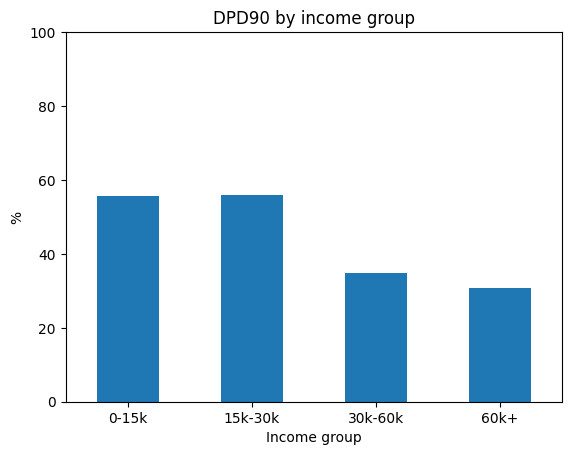

In [4]:
bins = [0, 15000, 30000, 60000, float('inf')]
labels = ['0-15k', '15k-30k', '30k-60k', '60k+']

dpd90_rates_income = dpd90.copy().drop(columns='age')
dpd90_rates_income['group_income'] = pd.cut(dpd90_rates_income['income'], bins=bins, labels=labels)
dpd90_rates_income = dpd90_rates_income.groupby('group_income', observed=True).agg(
    dpd90_rate=('dpd90', lambda x: (x.mean() * 100).round(2))
)

dpd90_rates_income['dpd90_rate'].plot(kind='bar', ylim=(0, 100), title='DPD90 by income group')
plt.xticks(rotation=0)
plt.xlabel('Income group')
plt.ylabel('%');